In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import warnings
warnings.filterwarnings('ignore')

import data_util as du

In [13]:
file = "data/combined_milas_hall/Flo2.3-A2-32.csv"
df = pd.read_csv(file)
df.head()

,timestamp,DprPos,FlSpt,HwVlvPos,RmTmp,RmTmpCspt,RmTmpHpst,SaFl
0,2020-10-09 14:00:00,30.632812,300.0,32.421875,68.351562,85.0,69.0,296.0
1,2020-10-09 14:15:00,30.820312,300.0,25.781250,68.398438,85.0,69.0,288.0
2,2020-10-09 14:30:00,31.851562,300.0,14.453125,68.703125,85.0,69.0,290.0
3,2020-10-09 14:45:00,31.289062,300.0,12.890625,68.828125,85.0,69.0,312.0
4,2020-10-09 15:00:00,31.007812,300.0,5.468750,68.890625,85.0,69.0,305.0


In [14]:
df.isnull().sum()

timestamp    0
DprPos       0
FlSpt        0
HwVlvPos     0
RmTmp        0
RmTmpCspt    0
RmTmpHpst    0
SaFl         0
dtype: int64

There doesn't seem to any null values

#### Basic Visualization

In [15]:
df = du.timestamp_split(file)
df.head()

,DprPos,FlSpt,HwVlvPos,RmTmp,RmTmpCspt,RmTmpHpst,SaFl,datetime
0,30.632812,300.0,32.421875,68.351562,85.0,69.0,296.0,2020-10-09 14:00:00
1,30.820312,300.0,25.781250,68.398438,85.0,69.0,288.0,2020-10-09 14:15:00
2,31.851562,300.0,14.453125,68.703125,85.0,69.0,290.0,2020-10-09 14:30:00
3,31.289062,300.0,12.890625,68.828125,85.0,69.0,312.0,2020-10-09 14:45:00
4,31.007812,300.0,5.468750,68.890625,85.0,69.0,305.0,2020-10-09 15:00:00


Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

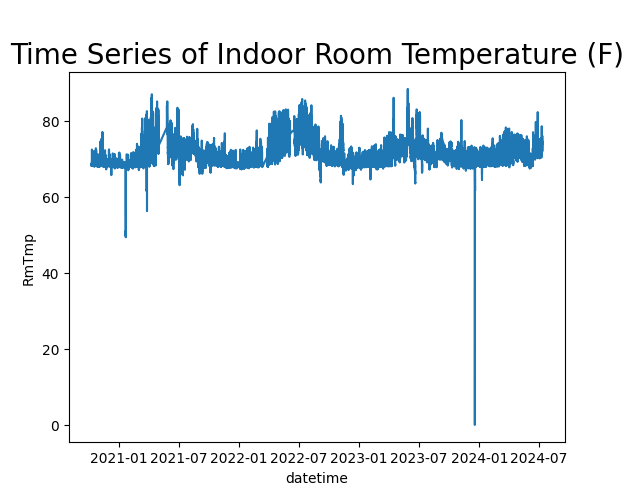

In [16]:
ax = sns.lineplot(data=df, x="datetime", y="RmTmp")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

Text(0.5, 1.0, '\nTime Series of Indoor Room Temperature (F)')

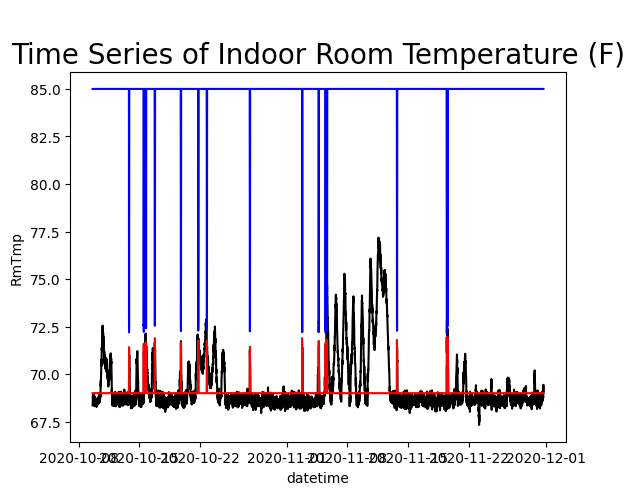

In [17]:
ax = sns.lineplot(data=df[:5000], x="datetime", y="RmTmp", color="black")
sns.lineplot(data=df[:5000], x="datetime", y="RmTmpCspt", color="blue")
sns.lineplot(data=df[:5000], x="datetime", y="RmTmpHpst", color="red")
ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

Plotting the setpoint changes, we see that often times they are at the maximum values, which is usually meant to be times when the room is unoccupied. We can filter out these to find the times when the temperature is unbounded and focus on just the spikes.

<AxesSubplot:xlabel='datetime', ylabel='RmTmp'>

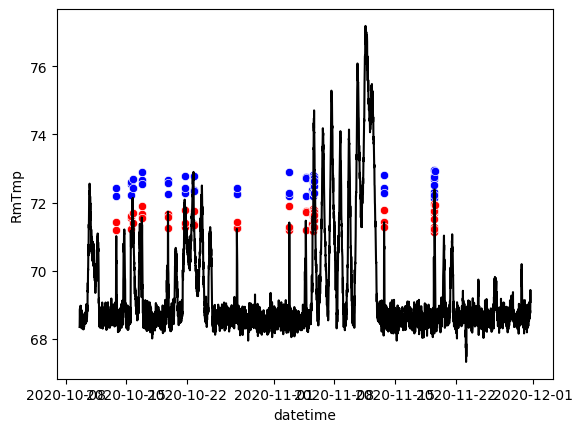

In [18]:
def filter_setpoint(df, top_threshold, bottom_threshold):
    df_filtered = df[df["RmTmpCspt"] < top_threshold]
    df_filtered = df_filtered[df["RmTmpHpst"] > bottom_threshold]
    return df_filtered

df_filtered = filter_setpoint(df[:5000], max(df["RmTmpCspt"]), min(df["RmTmpHpst"]))
ax = sns.lineplot(data=df[:5000], x="datetime", y="RmTmp", color="black")
sns.scatterplot(data=df_filtered, x="datetime", y="RmTmpCspt", color="blue")
sns.scatterplot(data=df_filtered, x="datetime", y="RmTmpHpst", color="red")

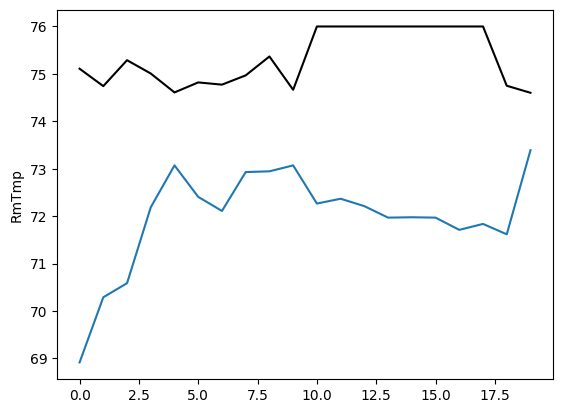

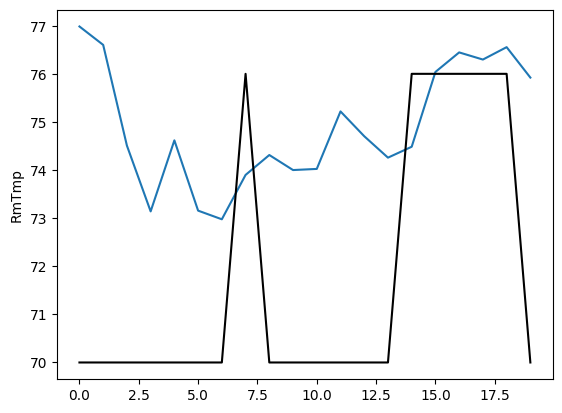

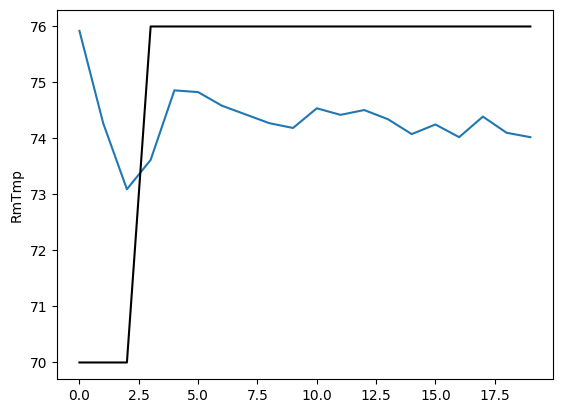

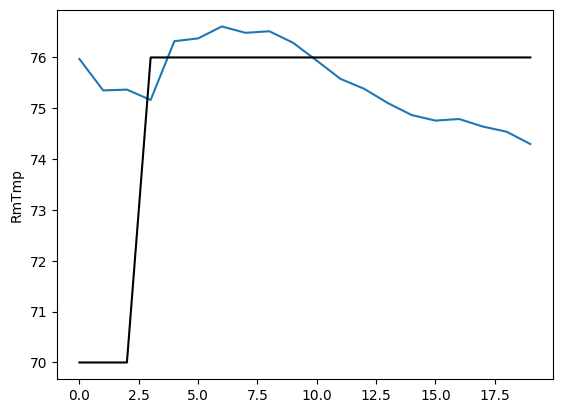

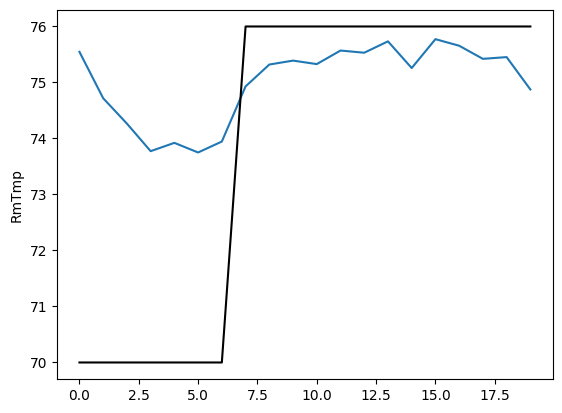

In [126]:
def filter_damper(df):
    df_filtered = df[df["FlSpt"] != 0.0]
    return df_filtered

def graph_filtered_setpoint(df):
    list_of_df = [d for _, d in df.groupby(df.index - np.arange(len(df)))]
    for new_df in list_of_df:
        if (new_df.head(1)["RmTmp"] >= (new_df.head(1)["RmTmpCspt"] + 5)).all() or (new_df.head(1)["RmTmp"] <= (new_df.head(1)["RmTmpCspt"] - 5)).all():
            sns.lineplot(data=new_df, x=np.arange(len(new_df)), y="RmTmp")
            sns.lineplot(data=new_df, x=np.arange(len(new_df)), y="RmTmpCspt", color="black")
            plt.show()

def graph_filtered_setpoint(df, df_full):
    list_of_df = [d for _, d in df.groupby(df.index - np.arange(len(df)))]
    for new_df in list_of_df:
        if (new_df.head(1)["RmTmp"] >= (new_df.head(1)["RmTmpCspt"] + 5)).all() or (new_df.head(1)["RmTmp"] <= (new_df.head(1)["RmTmpCspt"] - 5)).all():
            start_idx = new_df.index[0]
            # print(df_full.loc[range(start_idx, start_idx+10)])
            sns.lineplot(data=df_full.loc[range(start_idx, start_idx+20)], x=np.arange(20), y="RmTmp")
            sns.lineplot(data=df_full.loc[range(start_idx, start_idx+20)], x=np.arange(20), y="RmTmpCspt", color="black")
            plt.show()

df_filtered = filter_setpoint(df[115000:125000], df["RmTmpHpst"].max(), df["RmTmpHpst"].min())
# df_filtered = filter_damper(df[121000:121500])
graph_filtered_setpoint(df_filtered, df)

# ax = sns.lineplot(data=df[:100], x="datetime", y="RmTmp", color="black")
# sns.lineplot(data=df_filtered, x="datetime", y="RmTmpCspt", color="blue")
# sns.lineplot(data=df_filtered, x="datetime", y="RmTmpHpst", color="red")
# ax.axes.set_title("\nTime Series of Indoor Room Temperature (F)", fontsize=20)

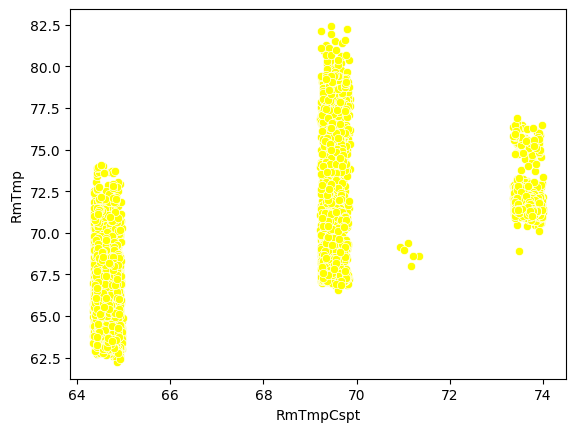

In [28]:
ax = sns.scatterplot(data=df[:5000], x="RmTmpCspt", y="RmTmp", color="yellow")

#### Downsampling
Smooth out data to remove hourly fluctuations and see more seasonal changes. From here, we can see
that there is a cycle that occurs  yearly basis. 

Text(0.5, 1.0, '\nAggregated Daily Temperature (F)')

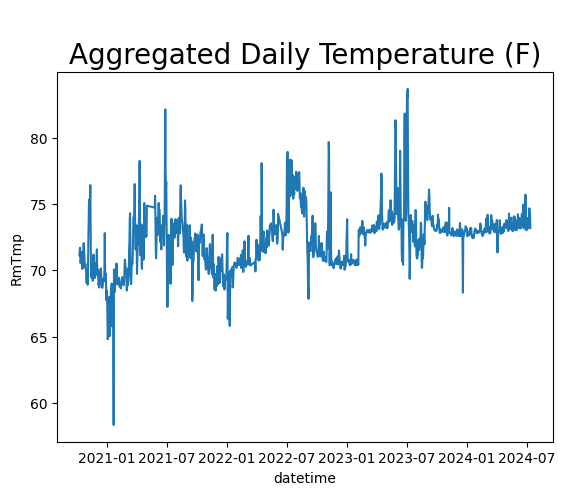

In [51]:
downsample_df = df.resample(rule="D", on="datetime").mean()
ax = sns.lineplot(data=downsample_df, x="datetime", y="RmTmp")
ax.axes.set_title("\nAggregated Daily Temperature (F)", fontsize=20)

#### Check for Stationary Data
Some models assume that the data is stationary, meaning that there is a constant mean (not time-dependent), constant variance (not time-dependent), and constant covariance (not time-dependent). We can try to check for this visually.

<AxesSubplot:xlabel='datetime', ylabel='RmTmp'>

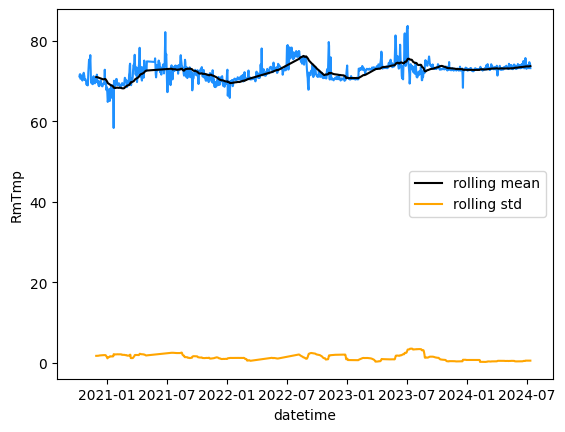

In [52]:
from pandas.plotting import autocorrelation_plot

rolling_window = 52 # 52 weeks per year

sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"], color="dodgerblue")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).mean(), color="black", label="rolling mean")
sns.lineplot(x=downsample_df.index, y=downsample_df["RmTmp"].rolling(rolling_window).std(), color="orange", label="rolling std")

ADF (Augmented Dickery-Fuller) test (null hypothesis is that the time series has a unit root (is not stationary). any p-value less than 0.05 means we can reject this and that the series IS stationary.)

In [42]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df["RmTmp"].values, autolag="AIC")
print(f"ADF Statistic Value: {result[0]}")
print(f"p-value: {result[1]}")
print("Critical Values:")
for key, value in result[4].items():
    print(f"    {key}: {value}")


KeyboardInterrupt: 

Based on this, since the p-value is close to 0 (statistical value < critical value>), the result is statistically significant and the series is stationary. This means any transformation is not necessary.

#### White Noise Test (Autocorrelation)
White noise is completely random with a mean of 0 with no pattern. We can check for this by looking at autocorrelation. In a white noise series, autocorrelation should be close to 0. 

#### Correlation of Each Variable
Check if there is any correlation between different variables and the room temperature

<AxesSubplot:xlabel='RmTmp', ylabel='SaFl'>

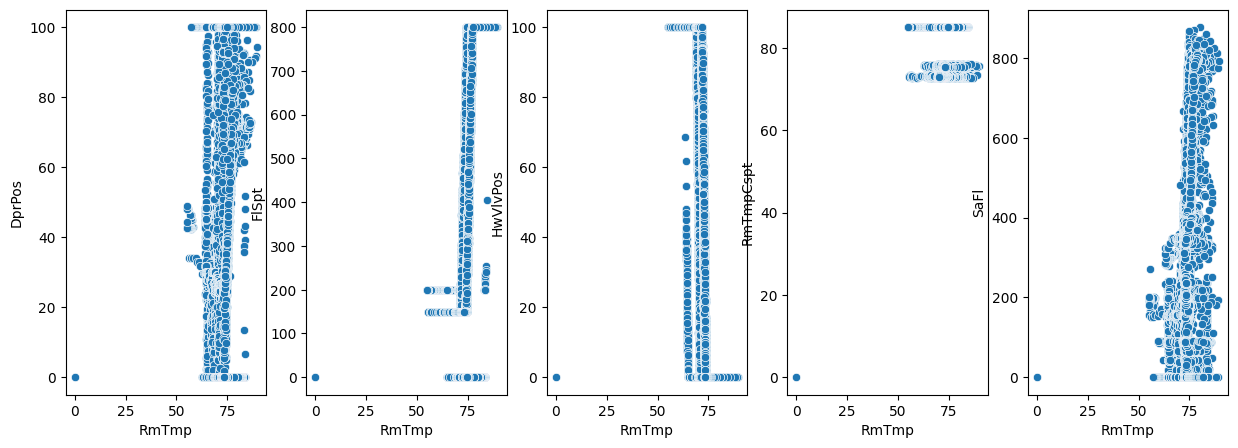

In [53]:
fig, ax = plt.subplots(1, 5, figsize=(15, 5))
sns.scatterplot(ax=ax[0], data=df, x="RmTmp", y="DprPos")
sns.scatterplot(ax=ax[1], data=df, x="RmTmp", y="FlSpt")
sns.scatterplot(ax=ax[2], data=df, x="RmTmp", y="HwVlvPos")
sns.scatterplot(ax=ax[3], data=df, x="RmTmp", y="RmTmpCspt")
sns.scatterplot(ax=ax[4], data=df, x="RmTmp", y="SaFl")